### Notes

#### Music sources

I found this after doing the internet archive work. It is likely a better choice, since
it has a variety of genres, and is a single zip. https://github.com/mdeff/fma

MIDI dataset

http://colinraffel.com/projects/lmd/#get

#### Indexing music

The Shazam algorithm is somewhat complex, and has nothing to do with deep learning.  Are we sure we want to use it?

# Building a Shazam clone

This notebook will walk through the steps needed to build a (simple) Shazam clone.  We'll first gather some music files from the Internet Archive.  Alternatively you can use your own library.  We then read and index them to allow for quick searching.

## Downloading from the Internet Archive

We want to download a number of files from the hiphop mixtape collection of the Internet Archive.  This collection is a good starting point as it contains a large variety of music from diverse artists and has enough tracks that we can  tell if we're doing a good job or not.

The webpage for this collection is here:  https://archive.org/details/hiphopmixtapes

Fortunately, the IA provides an API to access it and a Python library has been created to wrap the API already.  This simplifies our work significantly.

In [2]:
import internetarchive as ia
import os
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
# Run this the first time you use the library.  You'll need to register an IA account:
# https://archive.org/account/login.createaccount.php
# ia.configure()

In [3]:
MUSIC_DIR = os.path.expanduser('~/.cache/dl-cookbook/mp3')

def download_collection(max_items):
    count = 0
    archive_session = ia.session.ArchiveSession()
    search = ia.search.Search(archive_session, 'collection:hiphopmixtapes')
    for r in search.iter_as_items():
        kept_files = [
            f for f in r.files
            if (f['name'].endswith('.mp3') and
                float(f['size']) > 1*1000*1000 and
                float(f['size']) < 10*1000*1000)
        ]
        
        if not kept_files:
            continue
        
        r.download(files=[f['name'] for f in kept_files], destdir=MUSIC_DIR)
        count += len([f for f in r.files if f['name'].endswith('.mp3')])
        if count > max_items:
            return
    
os.system('mkdir -p "%s"' % MUSIC_DIR)

# This will take quite a while, and will use a few gigs of disk space.
download_collection(50)

01.IntelligentHoodlum: ............ - success
01.NAOCHOREMEUAMOR: ............ - success
01.Rebel: ... - success
01.RoleModel: ........ - success
01.YamborghiniHighFt.ASAPRockyASAPFergASAPNastASAPAntASAPTwelvyyJuicyJ: .......... - success
01BandoleroRemix: ..... - success


# Processing our data

Now that we have downloaded all of our music files, we want to build a search index for them.  This means we have to process them in a way that we can look up the right track given a short, noisy snippet of audio.  The authors of Shazam fortunately detail the process they use in this paper.  We will mostly follow the same mechanism:

https://github.com/papers-we-love/papers-we-love/blob/master/audio_comp_sci/shazam-audio-search-algorithm.pdf

## Reading MP3 files

There are a number of programs and libraries available for working with audio files, in this case MP3.  We're going to use librosa; it's easy to install with pip and provides a number of helpful utility functions we can make use of.

In [109]:
import librosa
import librosa.display

SAMPLE_RATE = 22050

reality = librosa.load(
    MUSIC_DIR + '/01.IntelligentHoodlum/02. Back To Reality.mp3',
    sr=SAMPLE_RATE,
    mono=True,
    res_type='kaiser_fast',
    dtype='float32'
)

In [116]:
samples = reality[0]
spectrograph = librosa.core.stft(samples[:SAMPLE_RATE*6], n_fft=1024)
spectrograph.shape

(513, 517)

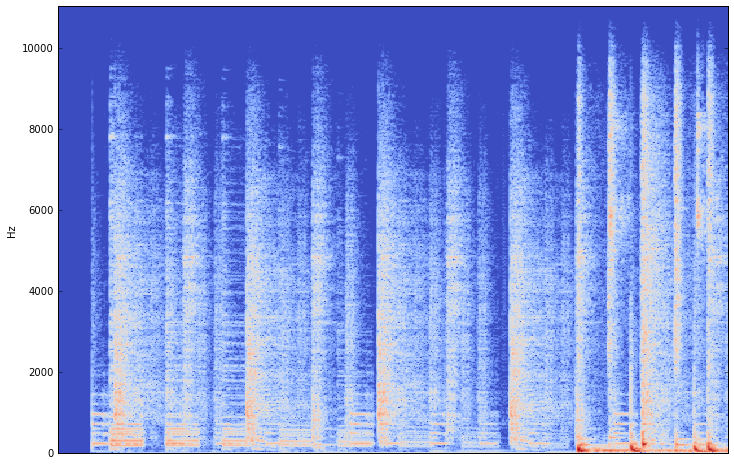

In [122]:
D = librosa.amplitude_to_db(spectrograph)
librosa.display.specshow(D, y_axis='linear')

In [123]:
def play(sample):
    librosa.output.write_wav('/tmp/foo.wav', sample, SAMPLE_RATE)
    os.system('aplay /tmp/foo.wav')

In [124]:
inverted = librosa.istft(np.real(spectrograph))
inverted.shape, play(inverted)

((132096,), None)

In [133]:
# Let's generate a spectrogram for every 10 seconds of audio, for all of our audio files.
#
# We will use multiprocessing to speed things up.
import multiprocessing
import numpy as np
import sys

SECONDS_PER_IMAGE = 6

def compute_spectographs(filename):
    samples = librosa.load(
        filename,
        sr=SAMPLE_RATE,
        mono=True,
        res_type='kaiser_fast',
        dtype='float32'
    )[0]
    
    output_prefix = filename + '.spectograph'
    
    for i, offset in enumerate(range(0, len(samples), SAMPLE_RATE * SECONDS_PER_IMAGE)):
        fname = output_prefix + '.%03d' % i
        spectrograph = librosa.core.stft(
            samples[i:i+(SAMPLE_RATE*SECONDS_PER_IMAGE)],
            n_fft=1024
        )
        np.save(fname, np.real(spectrograph))
    
def compute_all():
    pool = multiprocessing.Pool()    
    mp3s = os.popen("find '%s' -name '*.mp3'" % MUSIC_DIR).read().split('\n')
    mp3s = [f for f in mp3s if f.endswith('.mp3')]
    
    pool.map(compute_spectographs, mp3s)
    pool.close()
    pool.join()

compute_all()

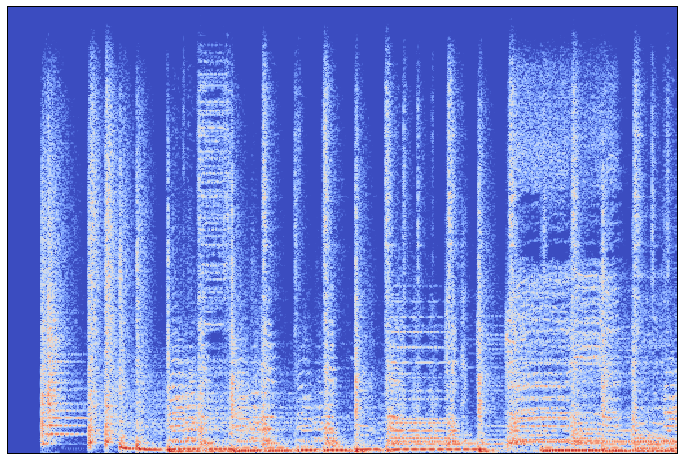

In [187]:
all_image_files = os.popen("find '%s' -name '*.npy'" % MUSIC_DIR).read().split('\n')
img = np.load(all_image_files[500])
librosa.display.specshow(librosa.amplitude_to_db(img))

In [137]:
img.shape, img.dtype, play(librosa.istft(img))

((513, 517), dtype('float32'), None)

## Generating music with a GAN

In [213]:
import keras
from keras.models import Model
import keras.layers as L
import keras.backend as K

img_width = 512
img_height = 512

# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

def build_gen_network(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    def deconv(layer, num_filters, kernel_size, strides=4, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, kernel_size, 
            padding=padding,
            strides=strides)(layer)
#         print(K.int_shape(layer))
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        return layer

    reshaped = deconv(reshaped, 256, 4, padding='valid', strides=1)
    reshaped = deconv(reshaped, 128, 4, padding='same')
    reshaped = deconv(reshaped, 64, 4, padding='same')
    reshaped = deconv(reshaped, 32, 4, padding='same')
    reshaped = deconv(reshaped, 16, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 1, 4, normalize=False, strides=1)    
    
    return Model(input=[input], output=[reshaped])

gen_network = build_gen_network(100)
gen_network.compile(loss='binary_crossentropy', optimizer='adam')
gen_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_78 (Conv2DT (None, 4, 4, 256)         409856    
_________________________________________________________________
batch_normalization_127 (Bat (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_128 (Bat (None, 16, 16, 128)       512       
__________

/home/power/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [210]:
def build_discriminator_network():
    input = L.Input(shape=(img_width, img_height, 1))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            strides=strides)(layer)
#        print(K.int_shape(layer))
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        return layer
    
    l = conv(input, 32, kernel_size=4, strides=2)
    l = conv(l, 64, kernel_size=4, strides=2)
    l = conv(l, 128, kernel_size=4, strides=2)
    l = conv(l, 256, kernel_size=4, strides=2)
    l = conv(l, 512, kernel_size=4, strides=2)
    l = conv(l, 1024, kernel_size=4, strides=2)
    l = L.Flatten()(l)
    l = L.Dense(units=1, activation='sigmoid')(l)
    
    return Model(input=[input], output=[l])

In [206]:
discriminator_network = build_discriminator_network()
discriminator_network.compile(loss='binary_crossentropy', optimizer='adam')
discriminator_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 256, 256, 32)      544       
_________________________________________________________________
batch_normalization_111 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 128, 128, 64)      32832     
_________________________________________________________________
batch_normalization_112 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 128, 128, 64)      0         
__________

/home/power/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [214]:
gan_input = L.Input(gen_network.input_shape[1:])
GAN = Model(gan_input, 
            discriminator_network(gen_network(gan_input)))
GAN.compile(loss='binary_crossentropy', optimizer='adam')
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_15 (Model)             (None, 512, 512, 1)       1108657   
_________________________________________________________________
model_11 (Model)             (None, 1)                 11250017  
Total params: 12,358,674
Trainable params: 1,107,665
Non-trainable params: 11,251,009
_________________________________________________________________


In [231]:
all_images = np.asarray([np.load(f) for f in all_image_files if f.strip()])
all_images = all_images[:, :512, :512, np.newaxis]
all_images /= (np.max(all_images) - np.min(all_images))

In [232]:
BATCH_SIZE = 8

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

d_loss = []
g_loss = []

for i in range(10):
    print('\r', i, flush=True, end='')
    noise_gen = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
    image_batch = all_images[np.random.randint(0, all_images.shape[0], size=BATCH_SIZE)]
    
    generated = gen_network.predict(noise_gen)
    X = np.concatenate((image_batch, generated))
    Y = np.zeros(2 * BATCH_SIZE)
    Y[:BATCH_SIZE] = 1
    make_trainable(discriminator_network, True)
    d_loss.append(discriminator_network.train_on_batch(X, Y))
    
    noise_tr = np.random.uniform(0, 1, size=(BATCH_SIZE,100))
    y2 = np.zeros(BATCH_SIZE)
    y2[:] = 1
    make_trainable(discriminator_network, False)
    g_loss.append(GAN.train_on_batch(noise_tr, y2))

 9

In [235]:
discriminator_network.predict(X)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)